<a id="table-of-contents"></a>
# 📖 Table of Contents

[📉 Dimensionality Reduction Overview](#dimensionality-reduction)  
- [🚧 Key Challenges in High Dimensions](#key-challenges)

[🗂️ Data Setup](#data-setup)  
- [🧾 Sample Data](#sample-data)

[📊 Principal Component Analysis (PCA)](#pca)  
- [⚙️ How PCA Works](#how-pca-works)  
- [📈 Scree Plot / Explained Variance](#explained-variance)  
- [🧭 Business Use Cases](#pca-business-use)

[🌌 t-SNE (t-Distributed Stochastic Neighbor Embedding)](#tsne)  
- [🔍 Intuition](#tsne-intuition)  
- [⚙️ How It Works](#how-tsne-works)  
- [🚫 Limitations](#tsne-limitations)  
- [🎯 When to Use](#when-to-use-tsne)  
- [📊 Visualizations](#tsne-visuals)

[🌐 UMAP (Uniform Manifold Approximation & Projection)](#umap)  
- [🔬 Intuition vs t-SNE](#umap-intuition)  
- [📈 Plot Interpretation](#umap-visuals)

[📐 Linear Discriminant Analysis (LDA)](#lda)  
- [🔢 How LDA Works](#how-lda-works)  
- [🧮 Step-by-Step Breakdown](#lda-steps)  
- [📉 Dimensionality Constraint](#lda-constraint)

<!-- [📌 Final Summary](#final-summary) -->

<!-- [❓ FAQ / Notes](#faq)  
- [🧠 When to Use What](#when-to-use-what)  
- [📏 Unsupervised vs Supervised Methods](#unsup-vs-sup)
 -->
<!-- <hr style="border: none; height: 1px; background-color: #ddd;" /> -->
[Back to the top](#table-of-contents)
___



<a id="dimensionality-reduction"></a>
# 📉 Dimensionality Reduction Overview

<details><summary><strong>📖 Explanation (Click to Expand) </strong></summary>
Dimensionality reduction refers to techniques that transform high-dimensional data into a lower-dimensional space — while preserving as much **useful structure or signal** as possible.

These methods are valuable across both modeling and business contexts:

- 🔄 **Simplifying data** for faster computation and easier storage  
- 📉 **Reducing overfitting** by eliminating noise or redundant features  
- 👀 **Visualizing hidden structure** in 2D or 3D  
- 📊 **Improving model interpretability** by focusing on key components

This notebook covers several popular approaches — PCA, t-SNE, UMAP, and LDA — each with distinct goals, assumptions, and business use cases.
</details>

<a id="key-challenges"></a>
#### 🚧 Key Challenges in High Dimensions

<details><summary><strong>📖 Explanation (Click to Expand) </strong></summary>
High-dimensional datasets (e.g., 100+ features) often seem rich, but pose several practical issues:

##### ❌ Curse of Dimensionality
- Distance metrics (like Euclidean) lose meaning
- Feature space becomes sparse — hard to model effectively
- Models require exponentially more data to generalize

##### 💻 Computational Overhead
- More dimensions = higher training time
- Resource-intensive for models like clustering or k-NN

##### 👁️ Visualization Limitations
- Human intuition maxes out at 3D — we need projection techniques to reveal structure

Dimensionality reduction helps address these problems by transforming the data to **lower, information-rich representations** — enabling both insight and performance.
</details>


[Back to the top](#table-of-contents)
___



<a id="data-setup"></a>
# 🗂️ Data Setup

<a id="sample-data"></a>
#### 🧾 Sample data

In [187]:
# Import Required Libraries

from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris





<details><summary><strong>📖 Explanation (Click to Expand) </strong></summary>

We'll simulate a retail scenario where each row represents a customer, and each column captures a behavioral signal — such as purchase frequency, monetary value, or product interaction features.

The goal is to apply dimensionality reduction techniques to:
- Identify underlying **customer personas**
- Compress features for **modeling efficiency**
- Enable **2D/3D visualization** of customer segments or churn patterns
</details>


In [208]:
# import numpy as np
# import pandas as pd

# np.random.seed(42)
# n_customers = 3000

# # --- Latent persona (still present but weakened) ---
# persona = np.random.normal(0, 1, n_customers)

# # --- Loosely correlated real signals ---
# monetary = 150 + 50 * persona + np.random.normal(0, 90, n_customers)
# frequency = 3 + 1.0 * persona + np.random.normal(0, 2.5, n_customers)
# cart_additions = 4 + 1.2 * persona + np.random.poisson(2, n_customers)
# promo_clicks = 3 + 0.8 * persona + np.random.normal(0, 4, n_customers)

# # --- Contradictory features ---
# # Bad customers view more, good customers convert faster (invert)
# page_views = 20 - 2 * persona + np.random.normal(0, 4, n_customers)

# # Cap feature (simulating saturation)
# support_tickets = np.minimum(np.random.poisson(1 + 0.2 * np.abs(persona), n_customers), 3)

# # Returns: class-dependent noise
# returns = np.where(persona > 1,
#                    np.random.binomial(n=1, p=0.25, size=n_customers),
#                    np.random.binomial(n=1, p=0.10, size=n_customers))

# # --- Skewed, mixed-type, nonlinear crap ---
# wishlist_items = np.random.geometric(p=0.3, size=n_customers)
# avg_discount = np.random.beta(2, 5, size=n_customers)
# membership_years = np.random.lognormal(mean=0.7, sigma=0.5, size=n_customers)
# referral_code_used = np.random.binomial(n=1, p=0.3, size=n_customers)

# # --- True junk features (pure noise) ---
# noise1 = np.random.normal(0, 1, n_customers)
# noise2 = np.random.uniform(0, 100, n_customers)
# noise3 = np.random.randint(0, 2, n_customers)

# # --- Composite engagement metric, but distorted ---
# engagement_score = (
#     (cart_additions - returns * 3 + promo_clicks * 1.5) +
#     np.random.normal(0, 15, n_customers)
# )

# # --- Assemble DataFrame ---
# df = pd.DataFrame({
#     'monetary': monetary,
#     'frequency': frequency,
#     'cart_additions': cart_additions,
#     'promo_clicks': promo_clicks,
#     'page_views': page_views,
#     'support_tickets': support_tickets,
#     'returns': returns,
#     'wishlist_items': wishlist_items,
#     'avg_discount': avg_discount,
#     'membership_years': membership_years,
#     'referral_code_used': referral_code_used,
#     'noise1': noise1,
#     'noise2': noise2,
#     'noise3': noise3,
#     'engagement_score': engagement_score
# })

# # Optional segment — muddy and not clean
# df['segment'] = np.select(
#     [
#         (df['monetary'] > 200) & (df['frequency'] > 5),
#         (df['monetary'] < 100) & (df['page_views'] > 25)
#     ],
#     ['High-Value', 'Churn-Risk'],
#     default='Unclear'
# )

# # Preview
# print(df.shape)
# df.head()


In [210]:
from sklearn.datasets import load_iris
import pandas as pd

# Load iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

# Optionally attach for LDA later
df = X.copy()
df['segment'] = y.replace({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

# Preview
print(df.shape)
df.head()


(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),segment
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


[Back to the top](#table-of-contents)
___


<a id="pca"></a>
# 📊 Principal Component Analysis (PCA)


#### 🔄 Standardizing the Features

<details><summary>📖 Explanation (Click to Expand) </summary>

Before applying PCA, it's important to **standardize** the dataset.

PCA is sensitive to the **scale** of features — variables with larger numeric ranges (e.g., `monetary`) would otherwise dominate the components just because of their magnitude.

We use `StandardScaler` to transform all features to have:
- **Mean = 0**
- **Standard Deviation = 1**

This ensures that each feature contributes equally when computing variance and covariance.

We exclude the `segment` label from this transformation since it's categorical and not part of the PCA input space.

</details>

In [292]:
# Automatically select only numeric columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))
scaled_data[0:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

#### 📈 Scree Plot: Cumulative Explained Variance

<details><summary>📖 Explanation (Click to Expand) </summary>

Once PCA is fitted on the scaled data, we calculate the **cumulative explained variance** — which tells us how much total information is retained by the top N principal components.

This plot helps answer a key question:
> "How many components do we actually need to keep most of the signal?"

The elbow or saturation point in the curve is often used as a natural cutoff. Annotating the cumulative variance percentages also makes it easier for business stakeholders to interpret the tradeoff between **dimensionality** and **information retention**.
<details>

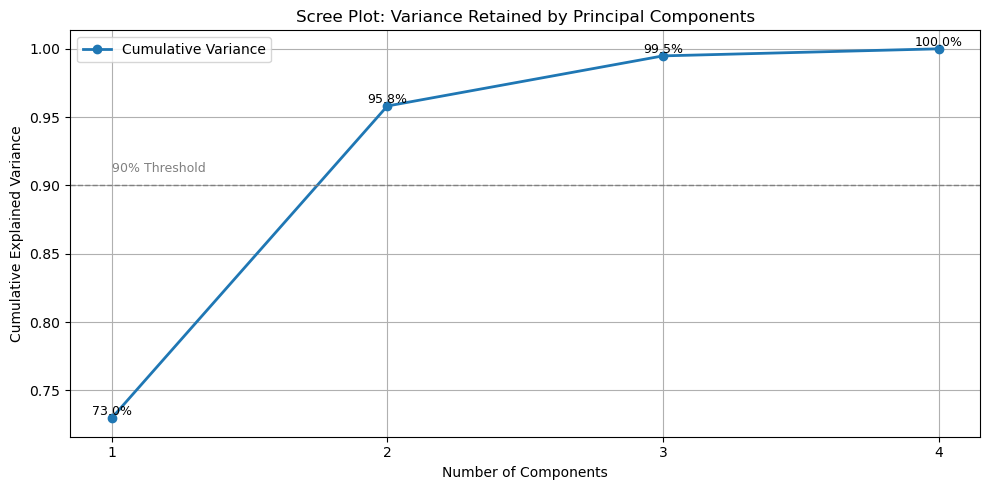

In [215]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA to get all components
pca_full = PCA()
pca_full.fit(scaled_data)

# Calculate cumulative explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    label='Cumulative Variance',
    linewidth=2
)

# Annotate each point with the cumulative % value
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var, f'{var * 100:.1f}%', ha='center', va='bottom', fontsize=9)

# Optional: add a horizontal reference line at 90%
plt.axhline(y=0.90, color='gray', linestyle='--', linewidth=1)
plt.text(1, 0.91, '90% Threshold', color='gray', fontsize=9)

# Styling
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: Variance Retained by Principal Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##### 📉 Apply PCA: Reducing to 2 Principal Components

<details><summary>📖 Explanation (Click to Expand) </summary>

Here, we reduce the dataset to its top 2 principal components using PCA. This helps in projecting high-dimensional data onto a 2D space, allowing us to visualize how well-separated the classes (species) are.

Each row in the output represents a transformed version of the original flower measurements, now compressed into `PC1` and `PC2` — the directions of highest variance in the data.
</details>

In [219]:
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(scaled_data)

# Convert results to DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add target labels for visualization (optional)
pca_df['Target'] = iris.target
pca_df


,PC1,PC2,Target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0
3,-2.299384,-0.597395,0
4,-2.389842,0.646835,0
...,...,...,...
145,1.870503,0.386966,2
146,1.564580,-0.896687,2
147,1.521170,0.269069,2
148,1.372788,1.011254,2


#### 📊 PCA Loadings: Feature Contributions

<details><summary>📖 Explanation (Click to Expand) </summary>

Loadings tell us how much each original feature contributes to each principal component. Think of it as a weighted recipe:

> PC1 = 0.52 × petal length − 0.28 × sepal width + ...

These values help interpret what each component actually means.

Note: The **sum of squared loadings per PC** is always ~1, due to PCA’s mathematical properties (unit vectors).
</details>


In [236]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=iris.feature_names
)

print("PCA Loadings:")
print(loadings)

# Sanity check: sum of squared loadings for each PC ≈ 1
print("\nSum of Squared Loadings per PC:")
print((loadings**2).sum(axis=0))


PCA Loadings:
                        PC1       PC2
sepal length (cm)  0.521066  0.377418
sepal width (cm)  -0.269347  0.923296
petal length (cm)  0.580413  0.024492
petal width (cm)   0.564857  0.066942

Sum of Squared Loadings per PC:
PC1    1.0
PC2    1.0
dtype: float64


#### 📊 Visualizing Feature Contributions to PCAs

<details><summary>📖 Explanation (Click to Expand) </summary>
These plots help us interpret PCA results more intuitively:

- The **first plot** shows raw loadings — how much each original feature contributes to each PC.
- The **second plot** shows how each original feature's variance is split across PCs (squared loadings).
- The **third plot** flips the view: it shows how each principal component is built from the original features.

Together, they help us answer:  
> "What are these principal components *really made of*?"

<details>

- Raw Loadings Plot (Feature contribution + direction)

/var/folders/9v/jtlv1fgs07x_4tf_v6kn4x6r0000gn/T/ipykernel_27242/2516908287.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


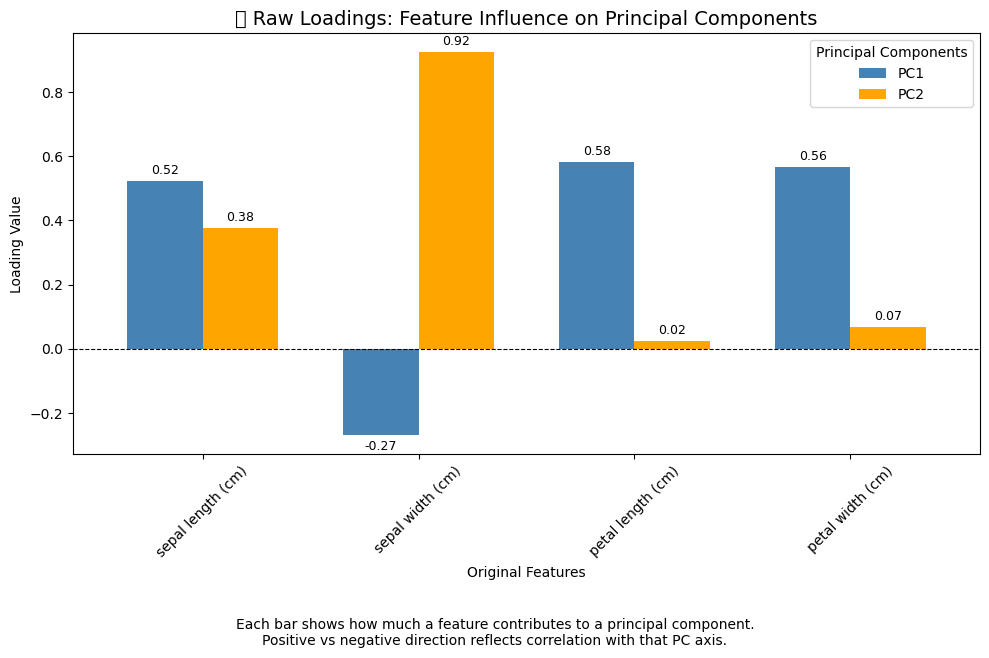

In [265]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = loadings.plot(kind='bar', ax=ax, width=0.7, color=['#4682B4', '#FFA500'])
ax.set_title('📊 Raw Loadings: Feature Influence on Principal Components', fontsize=14)
ax.set_ylabel('Loading Value')
ax.set_xlabel('Original Features')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.legend(title="Principal Components")
plt.xticks(rotation=45)

# Add annotations
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

# Explanation note
plt.figtext(0.5, -0.08, 
    "Each bar shows how much a feature contributes to a principal component.\n"
    "Positive vs negative direction reflects correlation with that PC axis.", 
    wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

- Feature-wise Stacked Plot (How each feature is explained across PCs)

/var/folders/9v/jtlv1fgs07x_4tf_v6kn4x6r0000gn/T/ipykernel_27242/1167610700.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


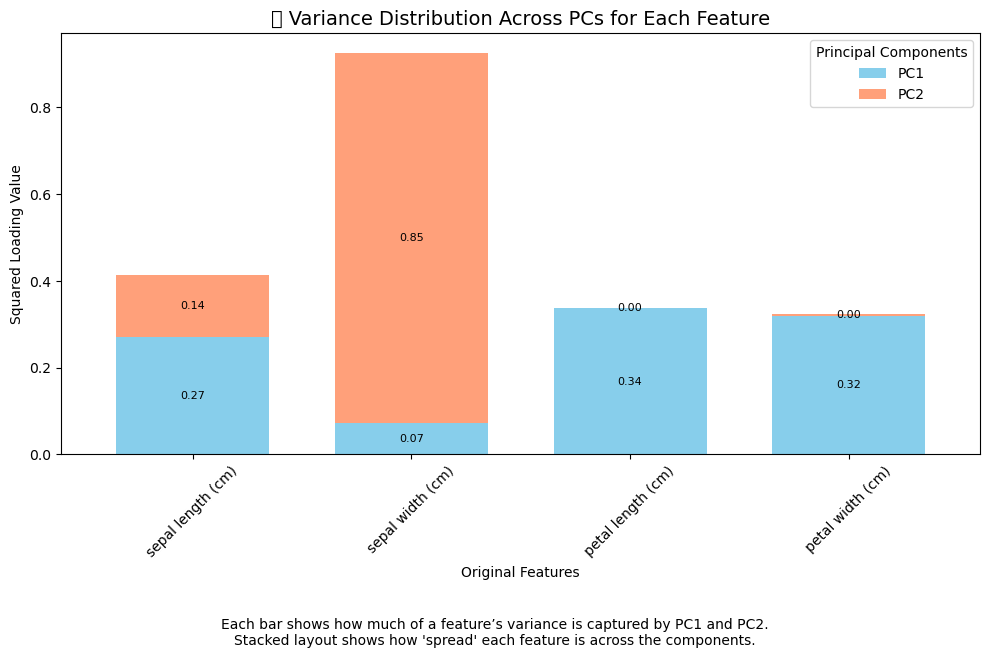

In [268]:
squared_loadings = loadings ** 2

fig, ax = plt.subplots(figsize=(10, 6))
bars = squared_loadings.plot(kind='bar', stacked=True, ax=ax, width=0.7, color=['#87CEEB', '#FFA07A'])
ax.set_title('🔍 Variance Distribution Across PCs for Each Feature', fontsize=14)
ax.set_ylabel('Squared Loading Value')
ax.set_xlabel('Original Features')
ax.legend(title="Principal Components")
plt.xticks(rotation=45)

# Add annotations
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

plt.figtext(0.5, -0.08, 
    "Each bar shows how much of a feature’s variance is captured by PC1 and PC2.\n"
    "Stacked layout shows how 'spread' each feature is across the components.",
    wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


- PC-wise Stacked Plot (What each PC is made of)

/var/folders/9v/jtlv1fgs07x_4tf_v6kn4x6r0000gn/T/ipykernel_27242/3555105797.py:22: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


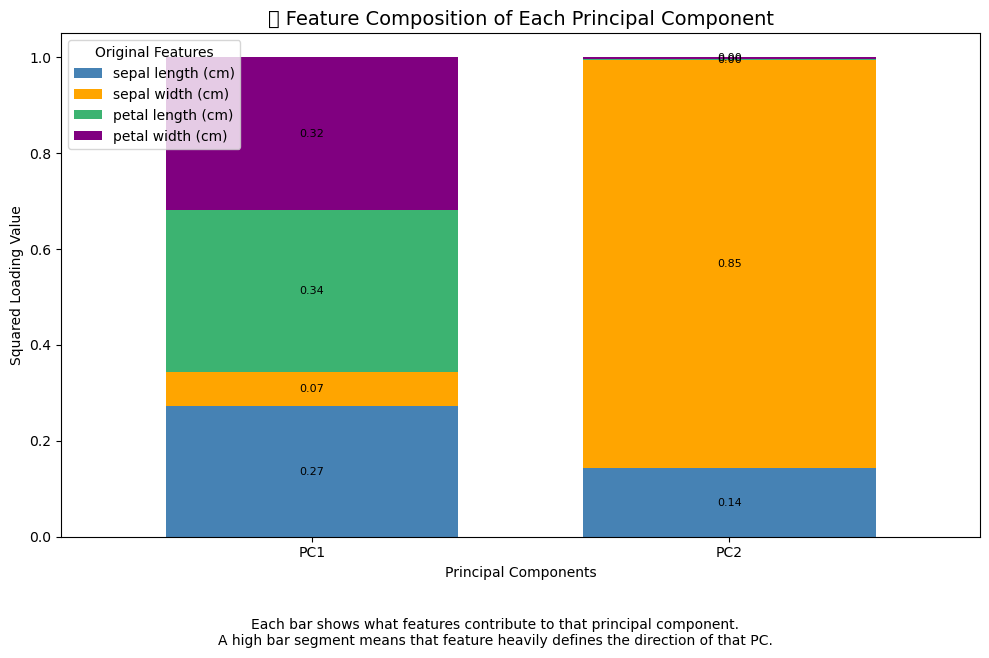

In [271]:
squared_T = squared_loadings.T

fig, ax = plt.subplots(figsize=(10, 6))
bars = squared_T.plot(kind='bar', stacked=True, ax=ax, width=0.7,
                      color=['#4682B4', '#FFA500', '#3CB371', '#800080'])

ax.set_title('🧬 Feature Composition of Each Principal Component', fontsize=14)
ax.set_ylabel('Squared Loading Value')
ax.set_xlabel('Principal Components')
ax.legend(title="Original Features")
plt.xticks(rotation=0)

# Annotate bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

plt.figtext(0.5, -0.08,
    "Each bar shows what features contribute to that principal component.\n"
    "A high bar segment means that feature heavily defines the direction of that PC.",
    wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


#### 🧭 Visualizing PCA Results in 2D

<details><summary>📖 Explanation (Click to Expand) </summary>

This scatter plot projects the Iris dataset onto the first two principal components (PC1 and PC2).

- Each point is a flower
- Colors represent the original species labels
- The separation between clusters tells us how well PCA captures the differences

Notice how **Setosa** is linearly separable, while **Versicolor** and **Virginica** overlap slightly — just like the original feature space.

This view is helpful for:
- Visual intuition
- Early clustering
- Pre-model dimensionality checks


/var/folders/9v/jtlv1fgs07x_4tf_v6kn4x6r0000gn/T/ipykernel_27242/3000030836.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(targets)).colors  # Dynamic color palette
/var/folders/9v/jtlv1fgs07x_4tf_v6kn4x6r0000gn/T/ipykernel_27242/3000030836.py:29: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


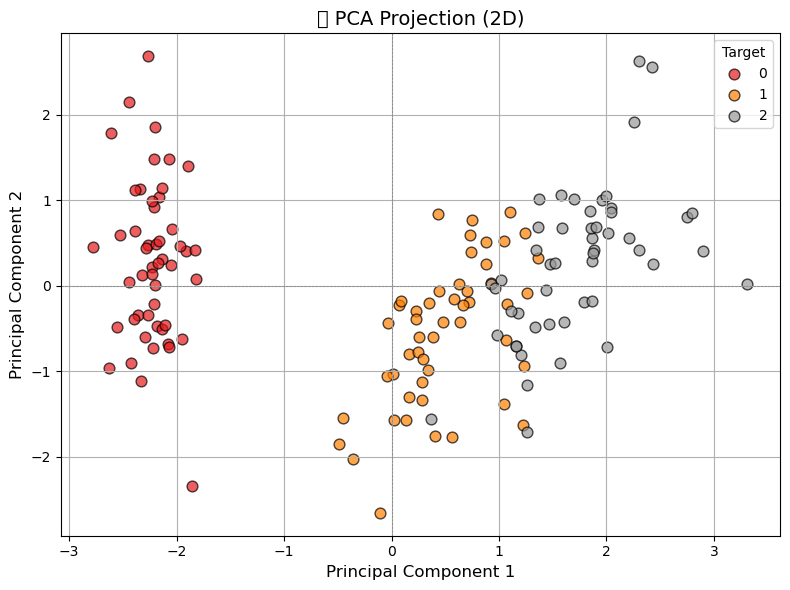

In [279]:
import matplotlib.pyplot as plt
import numpy as np

# Determine unique labels and colors dynamically
targets = pca_df['Target'].unique()
colors = plt.cm.get_cmap('Set1', len(targets)).colors  # Dynamic color palette

# Scatter plot of PCA results
plt.figure(figsize=(8, 6))

for target, color in zip(targets, colors):
    subset = pca_df[pca_df['Target'] == target]
    plt.scatter(
        subset['PC1'], subset['PC2'],
        label=target,
        color=color,
        alpha=0.7,
        edgecolor='k',
        s=60
    )

plt.title('🧭 PCA Projection (2D)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.axvline(0, color='grey', linewidth=0.5, linestyle='--')
plt.legend(title='Target', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


#### 📈 Variance Explained by Each Component

This section quantifies how much information (variance) is retained by each principal component.

- **Explained Variance**: The proportion of total variance captured by that component
- **Cumulative Variance**: How much total variance is retained up to that point

This helps determine how many components are needed to preserve most of the original data’s structure.



In [285]:
# Explained variance by each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Format nicely
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance), start=1):
    print(f"PC{i}: {ev:.4f} ({ev * 100:.2f}%) — Cumulative: {cv * 100:.2f}%")


PC1: 0.7296 (72.96%) — Cumulative: 72.96%
PC2: 0.2285 (22.85%) — Cumulative: 95.81%


[Back to the top](#table-of-contents)
___



<a id="tsne"></a>
# 🌌 t-SNE (t-Distributed Stochastic Neighbor Embedding)



<a id="tsne-intuition"></a>
#### 🔍 Intuition



<a id="how-tsne-works"></a>
#### ⚙️ How It Works



<a id="tsne-limitations"></a>
#### 🚫 Limitations



<a id="when-to-use-tsne"></a>
#### 🎯 When to Use



<a id="tsne-visuals"></a>
#### 📊 Visualizations



[Back to the top](#table-of-contents)
___



<a id="umap"></a>
# 🌐 UMAP (Uniform Manifold Approximation & Projection)



<a id="umap-intuition"></a>
#### 🔬 Intuition vs t-SNE



<a id="umap-visuals"></a>
#### 📈 Plot Interpretation



[Back to the top](#table-of-contents)
___



<a id="lda"></a>
# 📐 Linear Discriminant Analysis (LDA)



<a id="how-lda-works"></a>
#### 🔢 How LDA Works



<a id="lda-steps"></a>
#### 🧮 Step-by-Step Breakdown



<a id="lda-constraint"></a>
#### 📉 Dimensionality Constraint



[Back to the top](#table-of-contents)
___



<!-- <a id="final-summary"></a>
# 📌 Final Summary

 -->

<!-- [Back to the top](#table-of-contents)
___

 -->

[🔗 Canonical Correlation Analysis (CCA)](#cca)  
- [🧬 When It’s Useful](#when-to-use-cca)  
- [🔄 Intuition: PCA for Two Views](#cca-intuition)  
- [📉 Dimensionality Reduction via Correlation](#cca-dim-reduction)


<!-- <a id="faq"></a>
# ❓ FAQ / Notes

 -->

<!-- <a id="when-to-use-what"></a>
#### 🧠 When to Use What

 -->

<!-- <a id="unsup-vs-sup"></a>
#### 📏 Unsupervised vs Supervised Methods
 -->

<!-- [Back to the top](#table-of-contents)
___

 -->